In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Embedding, SimpleRNN

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load Datasets

In [2]:
listSkinImages = []
listImagesPaths = []
for image_ in os.listdir("./skinImages"):
    if image_.endswith(".jpg") or image_.endswith(".jpeg") or image_.endswith(".png"):
        listSkinImages.append(image_)
        listImagesPaths.append(f"skinImages/{image_}")


dfSkinImages = pd.DataFrame({"imagePath":listImagesPaths,"image_id":listSkinImages})
dfSkinImages["image_id"] = dfSkinImages["image_id"].str.replace(".jpg","")
print(dfSkinImages.shape)
dfSkinImages.head()

(10015, 2)


C:\Users\arash\AppData\Local\Temp\ipykernel_15016\2243501711.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  dfSkinImages["image_id"] = dfSkinImages["image_id"].str.replace(".jpg","")


,imagePath,image_id
0,skinImages/ISIC_0024306.jpg,ISIC_0024306
1,skinImages/ISIC_0024307.jpg,ISIC_0024307
2,skinImages/ISIC_0024308.jpg,ISIC_0024308
3,skinImages/ISIC_0024309.jpg,ISIC_0024309
4,skinImages/ISIC_0024310.jpg,ISIC_0024310


# Visualize Images

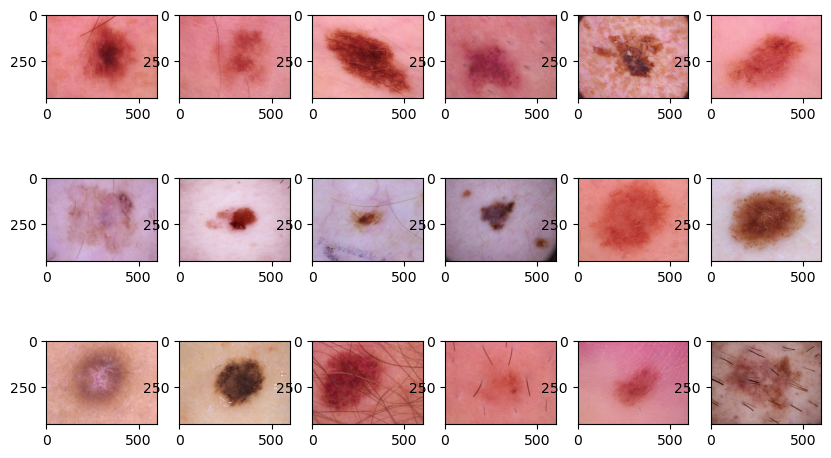

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(10, 6))
for index, row in dfSkinImages.iterrows():
    imagePath = row['imagePath']
    image_ = plt.imread(imagePath)
    axes[index // 6, index % 6].imshow(image_)
    if(index >16):
        break    
plt.show()

# EDA

In [4]:
dfLabels = pd.read_csv('HAM10000_metadata.csv')
dfLabels['label'] = dfLabels['dx']
dfLabels = dfLabels.replace({"label":{'akiec':0,'bcc': 1, 'bkl':2, 'df':3, 'nv':4, 'vasc':5, 'mel':6}})
dfLabels = pd.merge(dfLabels, dfSkinImages, on="image_id", how="left")
print(dfLabels.shape)
dfLabels.head()

(10015, 10)


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,imagePath
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,skinImages/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,skinImages/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,skinImages/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,skinImages/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,skinImages/ISIC_0031633.jpg


In [33]:
# ## We replace the null values with mean age
# dfLabels['age'].fillna((dfLabels['age'].mean()), inplace = True)
# print(dfLabels.isna().sum())

### Age Histogram

array([[<Axes: title={'center': 'age'}>]], dtype=object)

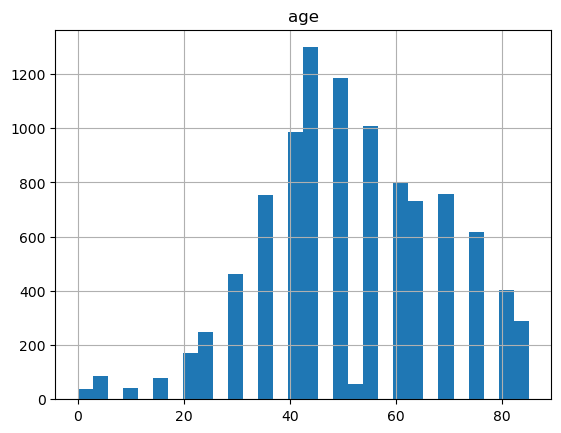

In [6]:
dfLabels.hist('age', bins=30)

### Cancerous Classes

<Axes: xlabel='dx'>

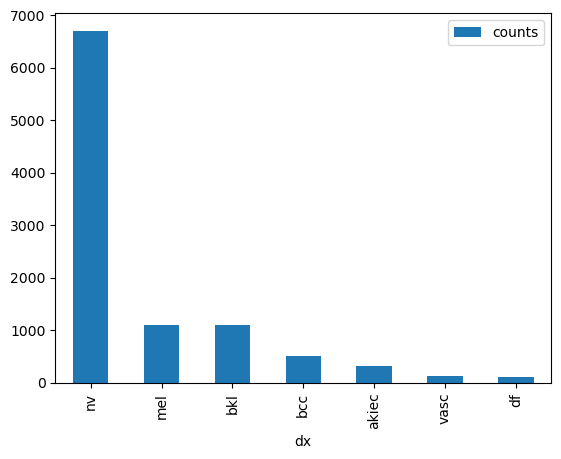

In [7]:
dfClasses = pd.DataFrame(dfLabels['dx'].value_counts()).reset_index()
dfClasses.columns = ['dx','counts']
dfClasses.plot.bar(x = 'dx', y= 'counts')

### Image Resolution

In [8]:
width  = image_.shape[1]
height = image_.shape[0]
print(f"Image width:  {width} pixels")
print(f"Image height: {height} pixels")

Image width:  600 pixels
Image height: 450 pixels


In [9]:
listImages = []
listCancerLabel = []
for index, row in dfLabels.iterrows():
    imagePath = row['imagePath']
    cancerLabel = row['label']
    image = Image.open(imagePath)
    image = image.resize((32, 32))
    listImages.append(np.array(image).astype('float32')/255.0)             # Convert to 3D matrix
    listCancerLabel.append(cancerLabel)

npImages = np.array(listImages)
npCancerLabel = np.array(listCancerLabel)
print(len(npImages))

10015


# Split Dataset into Training and Validations

In [10]:
# Split the data into training and testing sets
X_train , X_test , y_trainL , y_testL = train_test_split(npImages , npCancerLabel , test_size = 0.20 , random_state = 49)

print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_trainL.shape}\ny_test shape: {y_testL.shape}')

y_train = to_categorical(y_trainL)
y_test = to_categorical(y_testL)

X_train shape: (8012, 32, 32, 3)
X_test shape: (2003, 32, 32, 3)
y_train shape: (8012,)
y_test shape: (2003,)


In [30]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}
#---------------------------------------------------------------------------

def plotGraphs(history):
    trAcc   = history.history['accuracy']
    trLoss  = history.history['loss']
    valAcc  = history.history['val_accuracy']
    valLoss = history.history['val_loss']

    maxTrAcc = max(trAcc)
    maxTrAccEpoch = trAcc.index(maxTrAcc)
    maxValAcc = max(valAcc)
    minTrLoss = min(trLoss)
    minVaLoss = min(valLoss)
    listEpochs = [i for i in range(len(trAcc))]

    dfAcc = pd.DataFrame({"Training Accuracy": trAcc, "Validation Accuracy":valAcc })
    dfLoss = pd.DataFrame({"Training Loss":trLoss, "Validation Loss":valLoss })

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    sns.lineplot(data = dfAcc, ax = axes[0])
    sns.lineplot(data = dfLoss, ax = axes[1]) 
    sns.set_style("darkgrid")  
    plt.show()

## Build Model

In [14]:
model_ = Sequential()
model_.add(Input(shape=[32, 32, 3]))
model_.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model_.add(MaxPool2D())
model_.add(BatchNormalization())
model_.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model_.add(MaxPool2D())
model_.add(BatchNormalization())

model_.add(Flatten())
model_.add(Dense(128, activation = 'relu', kernel_initializer='he_normal'))
model_.add(BatchNormalization())
model_.add(Dropout(rate=0.5))
model_.add(Dense(64, activation = 'relu', kernel_initializer='he_normal'))
model_.add(BatchNormalization())
model_.add(Dense(7, activation = 'softmax'))
model_.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                        

In [15]:
history = model_.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
201/201 [==============================] - 25s 89ms/step - loss: 1.5538 - accuracy: 0.4976 - val_loss: 1.3993 - val_accuracy: 0.5814
Epoch 2/20
201/201 [==============================] - 16s 81ms/step - loss: 1.0089 - accuracy: 0.6600 - val_loss: 0.9108 - val_accuracy: 0.7155
Epoch 3/20
201/201 [==============================] - 15s 74ms/step - loss: 0.8374 - accuracy: 0.7176 - val_loss: 0.7961 - val_accuracy: 0.7324
Epoch 4/20
201/201 [==============================] - 14s 72ms/step - loss: 0.7810 - accuracy: 0.7285 - val_loss: 0.7460 - val_accuracy: 0.7405
Epoch 5/20
201/201 [==============================] - 15s 72ms/step - loss: 0.7330 - accuracy: 0.7341 - val_loss: 0.7599 - val_accuracy: 0.7249
Epoch 6/20
201/201 [==============================] - 19s 95ms/step - loss: 0.7089 - accuracy: 0.7435 - val_loss: 0.7049 - val_accuracy: 0.7511
Epoch 7/20
201/201 [==============================] - 16s 80ms/step - loss: 0.6903 - accuracy: 0.7522 - val_loss: 0.6945 - val_accuracy:

### Plot Performance Graphs

Max Training Accuracy:  83.77
Min Training Loss:  0.45
Max Validation Accuracy:  76.86
Min Validation Loss:  0.65


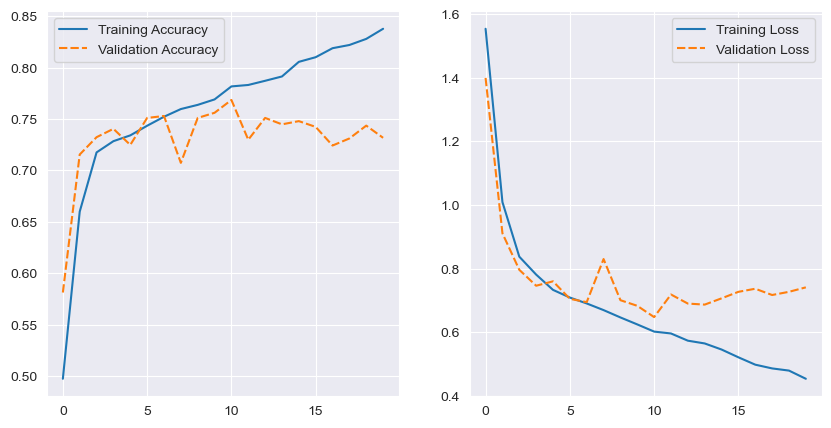

In [31]:
print("Max Training Accuracy: "   , round(max(history.history['accuracy'])*100,2))
print("Min Training Loss: "       , round(min(history.history['loss']),2))
print("Max Validation Accuracy: " , round(max(history.history['val_accuracy'])*100,2))
print("Min Validation Loss: "     , round(min(history.history['val_loss']),2))
plotGraphs(history)

# Model Evaluation

63/63 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.7424
Train Loss:  0.4158773422241211
Train Accuracy:  0.8624563217163086
--------------------
Test Loss:  0.6983184218406677
Test Accuracy:  0.7423864006996155
63/63 [==============================] - 0s 6ms/step
[4, 6, 2, 1, 5, 0, 3]


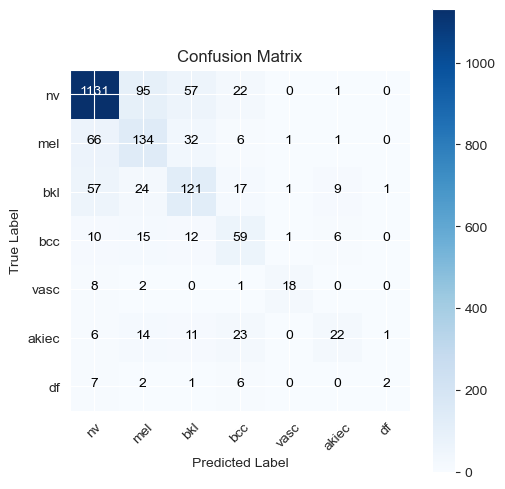

In [32]:
train_score = model_.evaluate(X_train, y_train, verbose= 1)
test_score = model_.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

y_true = np.array(y_test)
y_pred = model_.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)


# Confusion matrix
import itertools
cm =  confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
tick_labels = []
for key in classes:
    tick_labels.append(classes[key][0])
plt.xticks(tick_marks, tick_labels, rotation= 45)
plt.yticks(tick_marks, tick_labels)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()